In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

base_path = "/content/drive/MyDrive/SHL Task/dataset"
print(os.listdir(base_path))


['test.csv', 'train.csv', 'sample_submission.csv', 'audios_train', 'audios_test', 'shl-grammar-scoring.ipynb']


In [ ]:
!pip install -q openai-whisper nltk scikit-learn pandas tqdm librosa


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: Tesla T4


In [ ]:
base_path = "/content/drive/MyDrive/SHL Task/dataset"
train_df = pd.read_csv(os.path.join(base_path, "train.csv"))
test_df = pd.read_csv(os.path.join(base_path, "test.csv"))

print(train_df.shape, test_df.shape)
train_df.head()


(444, 2) (195, 1)


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [ ]:
import os
import whisper
import pandas as pd
import nltk
from nltk import word_tokenize, pos_tag
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
base_path = "/content/drive/MyDrive/SHL Task/dataset"

train_df = pd.read_csv(os.path.join(base_path, "train.csv"))
test_df = pd.read_csv(os.path.join(base_path, "test.csv"))

print(train_df.shape, test_df.shape)
train_df.head()


(444, 2) (195, 1)


,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [ ]:
model = whisper.load_model("base")  # Whisper-base works great with T4 GPU


100%|████████████████████████████████████████| 139M/139M [00:00<00:00, 169MiB/s]


In [ ]:
def extract_features(audio_path):
    # Transcribe speech to text
    result = model.transcribe(audio_path, fp16=False)
    text = result['text'].strip()

    # Tokenization + POS tagging
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    # Rule-based grammar features
    total_words = len(tokens)
    num_nouns = sum(1 for w, t in pos_tags if t.startswith('NN'))
    num_verbs = sum(1 for w, t in pos_tags if t.startswith('VB'))
    num_adjs = sum(1 for w, t in pos_tags if t.startswith('JJ'))
    avg_word_len = np.mean([len(w) for w in tokens]) if tokens else 0

    return {
        'text': text,
        'total_words': total_words,
        'num_nouns': num_nouns,
        'num_verbs': num_verbs,
        'num_adjs': num_adjs,
        'avg_word_len': avg_word_len
    }


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')   # ✅ NEW fix for NLTK 3.9+
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
import os
import whisper
import pandas as pd
import nltk
from nltk import word_tokenize, pos_tag
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np

# 🧠 Download all updated NLTK models
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')  # 🩵 New tagger fix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# path setup
base_path = "/content/drive/MyDrive/SHL Task/dataset"
progress_path = os.path.join(base_path, "train_progress.csv")

# Load existing progress if available
if os.path.exists(progress_path):
    train_features = pd.read_csv(progress_path).to_dict('records')
    start_index = len(train_features)
    print(f"✅ Resuming from {start_index} already processed files.")
else:
    train_features = []
    start_index = 0
    print("🚀 Starting fresh feature extraction...")

save_every = 20  # save progress every 20 audios

for i, row in tqdm(train_df.iloc[start_index:].iterrows(), total=len(train_df) - start_index):
    audio_path = os.path.join(base_path, "audios_train", row['filename'])
    try:
        feats = extract_features(audio_path)
        feats['label'] = row['label']
        train_features.append(feats)
    except Exception as e:
        print(f"❌ Error on {row['filename']}: {e}")

    # auto-save every 20 iterations
    if (i + 1) % save_every == 0 or (i + 1) == len(train_df):
        pd.DataFrame(train_features).to_csv(progress_path, index=False)
        print(f"💾 Saved progress at {i + 1 + start_index} files.")


🚀 Starting fresh feature extraction...


  5%|▍         | 20/444 [01:36<21:24,  3.03s/it]

💾 Saved progress at 20 files.


  9%|▉         | 40/444 [02:12<16:32,  2.46s/it]

💾 Saved progress at 40 files.


 14%|█▎        | 60/444 [02:53<09:26,  1.48s/it]

💾 Saved progress at 60 files.


 18%|█▊        | 80/444 [03:28<17:32,  2.89s/it]

💾 Saved progress at 80 files.


 23%|██▎       | 100/444 [04:03<10:14,  1.79s/it]

💾 Saved progress at 100 files.


 27%|██▋       | 120/444 [05:05<10:11,  1.89s/it]

💾 Saved progress at 120 files.


 32%|███▏      | 140/444 [06:09<09:01,  1.78s/it]

💾 Saved progress at 140 files.


 36%|███▌      | 160/444 [06:52<10:05,  2.13s/it]

💾 Saved progress at 160 files.


 41%|████      | 180/444 [07:32<07:53,  1.79s/it]

💾 Saved progress at 180 files.


 45%|████▌     | 200/444 [08:32<10:57,  2.69s/it]

💾 Saved progress at 200 files.


 50%|████▉     | 220/444 [09:47<07:00,  1.88s/it]

💾 Saved progress at 220 files.


 54%|█████▍    | 240/444 [10:34<10:06,  2.97s/it]

💾 Saved progress at 240 files.


 59%|█████▊    | 260/444 [11:46<13:08,  4.29s/it]

💾 Saved progress at 260 files.


 63%|██████▎   | 280/444 [12:35<06:32,  2.39s/it]

💾 Saved progress at 280 files.


 68%|██████▊   | 300/444 [13:42<05:44,  2.39s/it]

💾 Saved progress at 300 files.


 72%|███████▏  | 320/444 [15:29<09:09,  4.43s/it]

💾 Saved progress at 320 files.


 77%|███████▋  | 340/444 [17:01<11:32,  6.66s/it]

💾 Saved progress at 340 files.


 81%|████████  | 360/444 [18:19<08:25,  6.01s/it]

💾 Saved progress at 360 files.


 86%|████████▌ | 380/444 [20:10<05:58,  5.60s/it]

💾 Saved progress at 380 files.


 90%|█████████ | 400/444 [21:24<04:07,  5.62s/it]

💾 Saved progress at 400 files.


 95%|█████████▍| 420/444 [23:07<01:22,  3.43s/it]

💾 Saved progress at 420 files.


 99%|█████████▉| 440/444 [25:00<00:24,  6.10s/it]

💾 Saved progress at 440 files.


100%|██████████| 444/444 [25:15<00:00,  3.41s/it]

💾 Saved progress at 444 files.


In [ ]:
import pandas as pd
base_path = "/content/drive/MyDrive/SHL Task/dataset"

train_feat_df = pd.read_csv(os.path.join(base_path, "train_progress.csv"))
print(train_feat_df.shape)
train_feat_df.head()


(444, 7)


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len,label
0,nd my favourite hobbies cultivation of plants ...,36,12,3,3,4.666667,1.0
1,The playground looks like very clear and neat ...,45,8,7,4,4.000000,1.5
2,My Girl is to become an electrical employee. A...,29,10,5,3,5.103448,1.5
3,My favorite place is in Andhra Pradesh. It is ...,76,24,11,3,3.789474,1.5
4,"My favorite places, my favorite places, Mutti ...",128,32,11,12,3.734375,2.0


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

X = train_feat_df[['total_words', 'num_nouns', 'num_verbs', 'num_adjs', 'avg_word_len']]
y = train_feat_df['label']

rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf_model.fit(X, y)

# Evaluate on train set
y_pred = rf_model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"✅ Model trained successfully!")
print(f"Train MSE: {mse:.4f}")
print(f"Train R² Score: {r2:.4f}")

# Save the model
joblib.dump(rf_model, os.path.join(base_path, "grammar_rf_model.pkl"))


✅ Model trained successfully!
Train MSE: 0.3405
Train R² Score: 0.7251


['/content/drive/MyDrive/SHL Task/dataset/grammar_rf_model.pkl']

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

base_path = "/content/drive/MyDrive/SHL Task/dataset"
progress_path_test = os.path.join(base_path, "test_progress.csv")

print("🔍 Checking if previous test extraction exists...")

# If some progress already exists
if os.path.exists(progress_path_test):
    test_features = pd.read_csv(progress_path_test).to_dict('records')
    start_index = len(test_features)
    print(f"✅ Resuming from {start_index} already processed test files.")
else:
    test_features = []
    start_index = 0
    print("🚀 Starting fresh extraction for test set...")

save_every = 10  # save progress every 10 files

for i, row in tqdm(test_df.iloc[start_index:].iterrows(), total=len(test_df) - start_index):
    audio_path = os.path.join(base_path, "audios_test", row['filename'])
    try:
        feats = extract_features(audio_path)
        test_features.append(feats)
    except Exception as e:
        print(f"❌ Error on {row['filename']}: {e}")

    # Auto-save progress every 10 files
    if (i + 1) % save_every == 0 or (i + 1) == len(test_df):
        pd.DataFrame(test_features).to_csv(progress_path_test, index=False)
        print(f"💾 Saved test progress at {i + 1 + start_index} files.")


🔍 Checking if previous test extraction exists...
🚀 Starting fresh extraction for test set...


  5%|▌         | 10/195 [00:23<05:25,  1.76s/it]

💾 Saved test progress at 10 files.


 10%|█         | 20/195 [00:50<08:59,  3.08s/it]

💾 Saved test progress at 20 files.


 15%|█▌        | 30/195 [01:07<05:10,  1.88s/it]

💾 Saved test progress at 30 files.


 21%|██        | 40/195 [01:25<05:50,  2.26s/it]

💾 Saved test progress at 40 files.


 26%|██▌       | 50/195 [01:45<04:28,  1.85s/it]

💾 Saved test progress at 50 files.


 31%|███       | 60/195 [02:06<04:56,  2.20s/it]

💾 Saved test progress at 60 files.


 36%|███▌      | 70/195 [02:27<04:19,  2.08s/it]

💾 Saved test progress at 70 files.


 41%|████      | 80/195 [02:47<04:25,  2.31s/it]

💾 Saved test progress at 80 files.


 46%|████▌     | 90/195 [03:10<03:44,  2.14s/it]

💾 Saved test progress at 90 files.


 51%|█████▏    | 100/195 [03:32<02:56,  1.86s/it]

💾 Saved test progress at 100 files.


 56%|█████▋    | 110/195 [04:30<11:37,  8.20s/it]

💾 Saved test progress at 110 files.


 62%|██████▏   | 120/195 [05:08<05:34,  4.46s/it]

💾 Saved test progress at 120 files.


 67%|██████▋   | 130/195 [05:37<02:04,  1.92s/it]

💾 Saved test progress at 130 files.


 72%|███████▏  | 140/195 [06:05<02:10,  2.37s/it]

💾 Saved test progress at 140 files.


 77%|███████▋  | 150/195 [06:26<01:46,  2.37s/it]

💾 Saved test progress at 150 files.


 82%|████████▏ | 160/195 [06:59<01:31,  2.61s/it]

💾 Saved test progress at 160 files.


 87%|████████▋ | 170/195 [07:33<02:28,  5.95s/it]

💾 Saved test progress at 170 files.


 92%|█████████▏| 180/195 [08:14<01:00,  4.04s/it]

💾 Saved test progress at 180 files.


 97%|█████████▋| 190/195 [08:48<00:25,  5.02s/it]

💾 Saved test progress at 190 files.


100%|██████████| 195/195 [09:31<00:00,  2.93s/it]

💾 Saved test progress at 195 files.


In [ ]:
test_feat_df = pd.read_csv(os.path.join(base_path, "test_progress.csv"))
print("✅ Test features loaded successfully!")
print("Shape:", test_feat_df.shape)
test_feat_df.head()


✅ Test features loaded successfully!
Shape: (195, 6)


,text,total_words,num_nouns,num_verbs,num_adjs,avg_word_len
0,pr Miguel nameμα ま lei stood up,7,5,1,0,3.571429
1,my hobbies are playing cricket because I am a ...,60,14,14,0,3.900000
2,At this market you can find a lot of things. A...,143,32,21,4,3.538462
3,My goal is I become an interpreter in the prem...,78,19,16,3,4.012821
4,"Okay, in the market, there is a lot of people,...",127,28,19,9,3.606299


In [ ]:
import joblib
import os
import pandas as pd

base_path = "/content/drive/MyDrive/SHL Task/dataset"

# Load your trained Random Forest model
rf_model = joblib.load(os.path.join(base_path, "grammar_rf_model.pkl"))

# Prepare test features
X_test = test_feat_df[['total_words', 'num_nouns', 'num_verbs', 'num_adjs', 'avg_word_len']]

# Predict grammar scores
preds = rf_model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame({
    'filename': test_df['filename'],
    'label': preds
})

# Save the submission file
submission_path = os.path.join(base_path, "submission.csv")
submission.to_csv(submission_path, index=False)

print("✅ Final submission file saved successfully!")
print("📂 Path:", submission_path)
submission.head()


✅ Final submission file saved successfully!
📂 Path: /content/drive/MyDrive/SHL Task/dataset/submission.csv


,filename,label
0,audio_706.wav,4.274238
1,audio_800.wav,3.739299
2,audio_68.wav,3.156359
3,audio_1267.wav,3.586531
4,audio_683.wav,3.228601


In [1]:
!pip install gradio whisper nltk joblib librosa


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for whisper: filename=whisper-1.1.10-py3-none-any.whl size=41120 sha256=cdb8123f88b43dc7bda3d2dd1ef36289fd2d5df9eabaae23c5b28c938d9c40c4
  Stored in directory: /root/.cache/pip/wheels/34/b8/4e/9c4c3351d670e06746a340fb4b7d854c76517eec225e5b32b1
Successfully built whisper


In [2]:
!pip install gradio whisper nltk joblib librosa soundfile


In [3]:
!pip install gradio whisper nltk joblib soundfile


In [2]:
!pip install gradio whisper nltk joblib soundfile


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for whisper: filename=whisper-1.1.10-py3-none-any.whl size=41120 sha256=7949e6b6b233bf858529d33d09cc7a4aa18686f94d48014a85b3caf772c6a078
  Stored in directory: /root/.cache/pip/wheels/34/b8/4e/9c4c3351d670e06746a340fb4b7d854c76517eec225e5b32b1
Successfully built whisper


In [3]:
pip install openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 50.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for openai-whisper: filename=openai_whisper-20250625-py3-none-any.whl size=803979 sha256=481e2a8960a172b547208c315d1fccd50e3b704774ab641e4b8e7092c7167438
  Stored in directory: /root/.cache/pip/wheels/61/d2/20/09ec9bef734d126cba375b15898010b6cc28578d8afdde5869
Successfully built openai-whisper


In [7]:
!pip install gradio whisper nltk joblib soundfile


In [8]:
# ====================================================
# 🎙️ Grammar Scoring Engine — Satyam’s SHL Project
# ====================================================

import gradio as gr
import whisper
import nltk
import joblib
import soundfile as sf
import numpy as np
import pandas as pd
from nltk import word_tokenize, pos_tag
import tempfile
import os

# -----------------------------
# 1️⃣ Fix NLTK Dependency Errors
# -----------------------------
nltk.download('punkt')
nltk.download('punkt_tab')  # ✅ Required for latest NLTK versions
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')  # Optional backup

# -----------------------------
# 2️⃣ Load Whisper + RF Model
# -----------------------------
print("📦 Loading Whisper & Grammar Model...")
asr_model = whisper.load_model("base")  # Whisper base model for transcription
rf_model = joblib.load("/content/drive/MyDrive/SHL Task/dataset/grammar_rf_model.pkl")  # Trained RandomForest model

# -----------------------------
# 3️⃣ Feature Extraction Function
# -----------------------------
def extract_features_from_audio(audio_path):
    """
    Transcribes the audio and extracts simple linguistic features.
    """
    result = asr_model.transcribe(audio_path, fp16=False)
    text = result['text'].strip()

    # Tokenize + POS tagging
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    total_words = len(tokens)
    num_nouns = sum(1 for w, t in pos_tags if t.startswith('NN'))
    num_verbs = sum(1 for w, t in pos_tags if t.startswith('VB'))
    num_adjs = sum(1 for w, t in pos_tags if t.startswith('JJ'))
    avg_word_len = np.mean([len(w) for w in tokens]) if total_words > 0 else 0

    features = {
        "total_words": total_words,
        "num_nouns": num_nouns,
        "num_verbs": num_verbs,
        "num_adjs": num_adjs,
        "avg_word_len": avg_word_len
    }

    return text, features

# -----------------------------
# 4️⃣ Main Prediction Function
# -----------------------------
def predict_grammar_score(audio):
    """
    Takes audio (from Gradio), extracts linguistic features,
    and predicts a grammar score using the trained model.
    """
    if audio is None:
        return "Please upload an audio file!", None, None

    sr, data = audio  # (sample_rate, waveform)
    with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
        sf.write(tmp.name, data, sr)  # ✅ Safe audio write
        audio_path = tmp.name

    # Extract features
    text, features = extract_features_from_audio(audio_path)
    X = pd.DataFrame([features])

    # Predict score
    score = rf_model.predict(X)[0]
    feature_summary = "\n".join([f"{k}: {v}" for k, v in features.items()])

    return text, feature_summary, f"{score:.2f} / 5.0"

# -----------------------------
# 5️⃣ Gradio User Interface
# -----------------------------
interface = gr.Interface(
    fn=predict_grammar_score,
    inputs=gr.Audio(type="numpy", label="🎤 Upload or Record English Speech (WAV/MP3)"),
    outputs=[
        gr.Textbox(label="🗣️ Transcription"),
        gr.Textbox(label="📊 Linguistic Features"),
        gr.Textbox(label="🧮 Predicted Grammar Score (0–5 Scale)")
    ],
    title="🎙️ Grammar Scoring Engine — Satyam’s SHL Project",
    description="Upload or record English speech. This app transcribes audio using Whisper, extracts linguistic features (POS-based), and predicts a grammar score using a Random Forest model trained on the SHL dataset.",
    theme="default"
)

# -----------------------------
# 6️⃣ Launch App
# -----------------------------
if __name__ == "__main__":
    interface.launch(share=True, debug=False)  # ✅ Disable debug to avoid async loop error


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


📦 Loading Whisper & Grammar Model...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0fee844ace19c4092c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


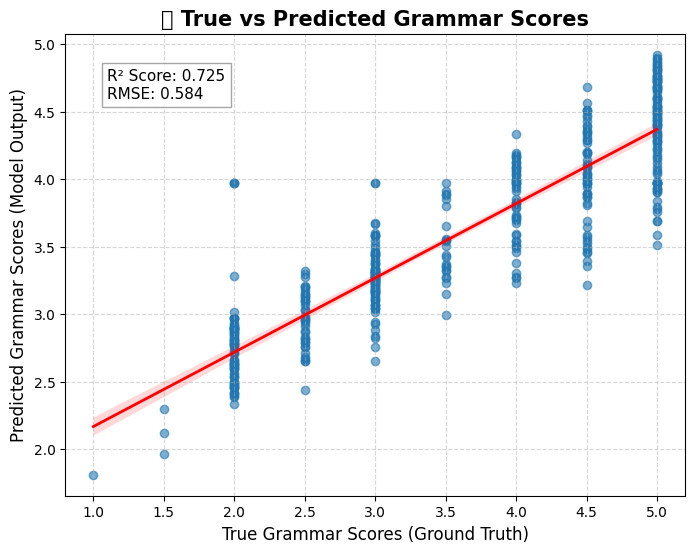

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Load feature data and trained model
train_feat_df = pd.read_csv("/content/drive/MyDrive/SHL Task/dataset/train_progress.csv")
rf_model = joblib.load("/content/drive/MyDrive/SHL Task/dataset/grammar_rf_model.pkl")

# Extract features and true labels
X = train_feat_df[["total_words", "num_nouns", "num_verbs", "num_adjs", "avg_word_len"]]
y_true = train_feat_df["label"]
y_pred = rf_model.predict(X)

# Compute metrics
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.regplot(x=y_true, y=y_pred, scatter_kws={'alpha': 0.6, 'color': '#1f77b4'},
            line_kws={'color': 'red', 'lw': 2})

plt.title("📊 True vs Predicted Grammar Scores", fontsize=15, weight='bold')
plt.xlabel("True Grammar Scores (Ground Truth)", fontsize=12)
plt.ylabel("Predicted Grammar Scores (Model Output)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Annotate metrics
plt.text(1.1, 4.6, f"R² Score: {r2:.3f}\nRMSE: {rmse:.3f}",
         fontsize=11, bbox=dict(facecolor='white', alpha=0.7, edgecolor='grey'))

plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


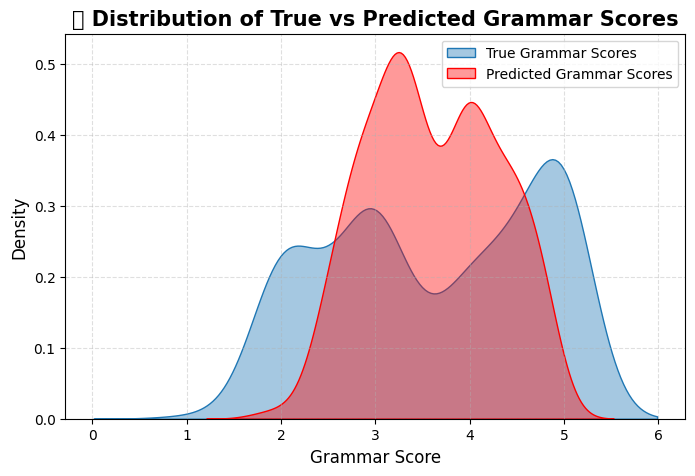

In [7]:
# Distribution comparison
plt.figure(figsize=(8, 5))
sns.kdeplot(y_true, label="True Grammar Scores", fill=True, alpha=0.4)
sns.kdeplot(y_pred, label="Predicted Grammar Scores", fill=True, alpha=0.4, color="red")

plt.title("📈 Distribution of True vs Predicted Grammar Scores", fontsize=15, weight='bold')
plt.xlabel("Grammar Score", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()
